In [1]:
%gui wx
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### load libraries, functions, colormap

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from mayavi import mlab
from sklearn.utils.arpack import eigsh
from sklearn.cluster import KMeans
import seaborn as sns
from vtk_rw import read_vtk, write_vtk

In [3]:
from __future__ import division

this version of read_vtk only works if there is data attached to the nodes, need to make it optional

cmap created with sns.palplot(sns.color_palette("Set2", 7)), then adding grey in the beginning. For use with mayavi transformed to array, added alpha value and multiply all by 255

In [4]:
cmap_7=np.zeros((8,4))
cmap_7[0,:]=[0.6, 0.6, 0.6, 1]
cmap_7[7,:]=[0.8, 0.6151497514677574, 0.11111, 1]
cmap_7[2,:]=[0.89573241682613591, 0.76784315109252932, 0.58182240093455595,1]
cmap_7[3,:]=[0.86, 0.37119999999999997, 0.34,1]
cmap_7[4,:]=[0.9677975592919913, 0.44127456009157356, 0.5358103155058701,1]
cmap_7[5,:]=[0.46810256823426105, 0.6699492535792404, 0.1928958739904499,1]
cmap_7[6,:]=[0.20125317221201128, 0.6907920815379025, 0.6,1]
cmap_7[1,:]=[0.21044753832183283, 0.55, 0.7,1]
cmap_255_7=np.zeros_like(cmap_7)
for row in range(cmap_7.shape[0]):
    cmap_255_7[row]=[np.floor(i * 255) for i in cmap_7[row]]
cmap_255_7=cmap_255_7.astype(int)

In [5]:
cmap_8=np.zeros((9,4))
cmap_8[0,:]=[0.6, 0.6, 0.6, 1]
cmap_8[8,:]=[0.8, 0.6151497514677574, 0.11111, 1]
cmap_8[2,:]=[0.89573241682613591, 0.76784315109252932, 0.58182240093455595,1]
cmap_8[3,:]=[0.86, 0.37119999999999997, 0.34,1]
#cmap_8[4,:]=[0.9677975592919913, 0.44127456009157356, 0.5358103155058701,1]
cmap_8[4,:]=[0.75, 0.4, 0.5,1]
cmap_8[5,:]=[0.8616090647292522, 0.536495730113334, 0.19548899031476086,1]
cmap_8[6,:]=[0.46810256823426105, 0.6699492535792404, 0.1928958739904499,1]
cmap_8[7,:]=[0.20125317221201128, 0.6907920815379025, 0.6,1]
cmap_8[1,:]=[0.21044753832183283, 0.55, 0.7,1]
#cmap_9[0,:]=[0.0,0.0,0.0,1.0]
cmap_255_8=np.zeros_like(cmap_8)
for row in range(cmap_8.shape[0]):
    cmap_255_8[row]=[np.floor(i * 255) for i in cmap_8[row]]
cmap_255_8=cmap_255_8.astype(int)

In [6]:
cmap_9=np.zeros((10,4))
cmap_9[0,:]=[0.6, 0.6, 0.6, 1]
cmap_9[9,:]=[0.8, 0.6151497514677574, 0.11111, 1]
cmap_9[2,:]=[0.89573241682613591, 0.76784315109252932, 0.58182240093455595,1]
cmap_9[3,:]=[0.86, 0.37119999999999997, 0.34,1]
cmap_9[4,:]=[0.9677975592919913, 0.44127456009157356, 0.5358103155058701,1]
cmap_9[5,:]=[0.75, 0.4, 0.5,1]
cmap_9[6,:]=[0.8616090647292522, 0.536495730113334, 0.19548899031476086,1]
cmap_9[7,:]=[0.46810256823426105, 0.6699492535792404, 0.1928958739904499,1]
cmap_9[8,:]=[0.20125317221201128, 0.6907920815379025, 0.6,1]
cmap_9[1,:]=[0.21044753832183283, 0.55, 0.7,1]
#cmap_9[0,:]=[0.0,0.0,0.0,1.0]
cmap_255_9=np.zeros_like(cmap_9)
for row in range(cmap_9.shape[0]):
    cmap_255_9[row]=[np.floor(i * 255) for i in cmap_9[row]]
cmap_255_9=cmap_255_9.astype(int)

In [7]:
cmap=[cmap_7, cmap_8, cmap_9]
cmap_255=[cmap_255_7, cmap_255_8, cmap_255_9]

#### load relevant files for subject and hemisphere

In [37]:
hemi='rh'
embed=3
k=17

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/%s_mask.1D.roi'%hemi
embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/raw/%s_embed_%s.csv'%(hemi, str(embed))
kmeans_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/clust/raw/%s_kmeans_%s_embed_%s.csv'%(hemi, str(k), str(embed))





#func_file=data_dir+'rest1_1_meshsmooth_%s/%s_%s_mid_simple_0.01_rest_%s_smoothdata.vtk'%(smooth, sub, hemi, hemi)
#t1_file=data_dir+'t1_smooth_1.5_mesh/%s_%s_mid_simple_0.01_t1_smooth1.5_%s.vtk'%(sub, hemi, hemi)

#var_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_var.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#t_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_avg_t.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#p_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_avg_p.csv'%(str(n_components_kmeans),smooth, sub, hemi)
#fig_file=data_dir+'/results_k%s_s%s_other/%s_%s_cluster_violins.svg'%(str(n_components_kmeans),smooth, sub, hemi)

pal=cmap[0]
pal_255=cmap_255[0]

In [38]:
#vt,ft,dt=read_vtk(t1_file)
#t1=dt['val'][:,0]

#xt=vt['val'][:,0]
#yt=vt['val'][:,1]
#zt=vt['val'][:,2]
#trianglest=ft['val']

v,f,d = read_vtk(mesh_file)

mask = np.loadtxt(mask_file)[:,0]
embed=np.loadtxt(embed_file, delimiter=',')
clust=np.loadtxt(kmeans_file, delimiter=',')

x=v[:,0]
y=v[:,1]
z=v[:,2]
triangles=f

In [39]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(x,y,z,triangles,scalars=clust, colormap='RdBu')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

#### Get T1 values in all clusters

In [11]:
# make a list of dictionaries for each cluster k0, k1, ...(0=mask to max kmeans) 
# and subcluster s0_1, s1_1, s1_2, ..(1 to max subcluster, no 0 subcluster)
t1_clust={}
for c in range(int(clust.max()+1)):
    t1_clust['k'+str(c)]=[]

# write all t1 values in one cluster into the list of its dictionary
for i in range(len(t1)):
    if t1[i]>1000:
        k=int(clust[i])
        t1_clust['k'+str(k)].append(t1[i])

#### Compare variance of kmeans cluster vs all other clusters and mean between all clusters

In [12]:
levene_array=np.zeros((6,int(clust.max())))
col=[]
sigk=[]
for c1 in range(int(clust.max())):
    a=t1_clust['k'+str(c1+1)]
    b=[]
    for c2 in range(int(clust.max())):
        if (c2+1) != (c1+1):
            b+=t1_clust['k'+str(c2+1)]
    W,p=stats.levene(a, b)
    col.append(int(c1+1))
    levene_array[0,c1]=W
    levene_array[1,c1]=p
    levene_array[2,c1]=np.var(a)
    levene_array[3,c1]=np.var(b)
    if p <(0.05/int(clust.max())):
        levene_array[4,c1]=True
    else:
        levene_array[4,c1]=False
    
    if np.var(a)<np.var(b):
        levene_array[5,c1]=True
    else:
        levene_array[5,c1]=False
        
    if (levene_array[4,c1]==True) and (levene_array[5,c1]==True):
        sigk.append(c1+1)
    #print 'levene k'+str(c1+1)+' vs all other clusters:', W, p
    #print 'variance k'+str(c1+1), np.var(a)
    #print 'variance all others', np.var(b)
    #print ''


    
levene_df=pd.DataFrame(levene_array, columns=col, index=['W', 'p', 'var k', 'var other', 'p<0.05/k', 'var decrease'])
levene_df.to_csv(var_file)

In [13]:
t_array=np.zeros((int(clust.max()),int(clust.max())))
p_array=np.zeros((int(clust.max()),int(clust.max())))
col2=[]
for c1 in range(int(clust.max())):
    for c2 in range(int(clust.max())):
        if c2>=c1:
            a=t1_clust['k'+str(c1+1)]
            b=t1_clust['k'+str(c2+1)]
            t,p=stats.ttest_ind(a, b)
            t_array[c1][c2]=t
            p_array[c1][c2]=p
    col2.append(c1+1)
t_df=pd.DataFrame(t_array, columns=col2, index=col2)
p_df=pd.DataFrame(p_array, columns=col2, index=col2)

t_df.to_csv(t_file)
p_df.to_csv(p_file)

#### Plot clustering, T1 values, Levene's statistics and T statistics

In [14]:
plot_list=[]
for c in range(int(clust.max())):
    plot_list+=[np.array(t1_clust['k'+str(c+1)])]
    
names=[]
for c in range(int(clust.max())):
    names.append(str(c+1))

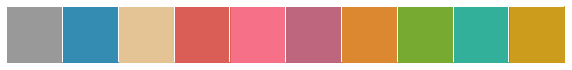

In [15]:
sns.palplot(pal)

/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:1367: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return values[idx]
/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:1367: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return values[idx]
/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:1367: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return values[idx]
/usr/lib/python2.7/dist-packages/scipy/stats/stats.py:1367: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return values[idx]


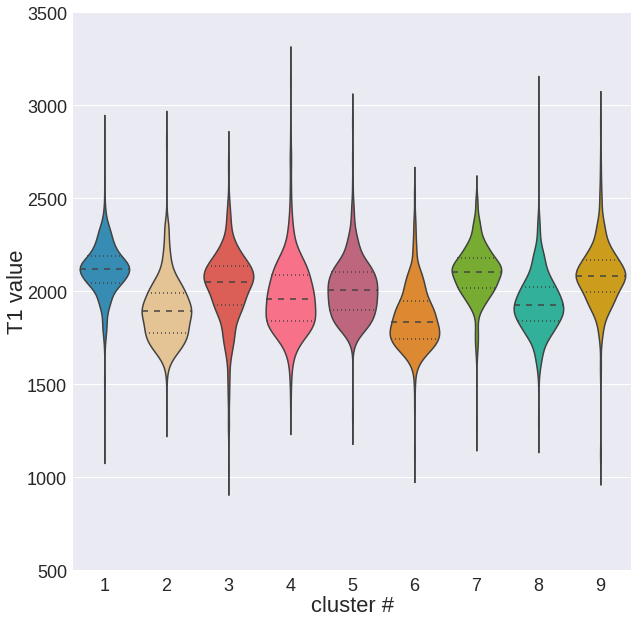

In [16]:
sns.set_context('notebook', font_scale=1.8)
fig = plt.figure(figsize=(10,10))
sns.violinplot(plot_list, color=pal[1:], names=names, saturation=1)
sns.axlabel('cluster #','T1 value', fontsize=22)
savefig(fig_file)

Variance comparison

In [17]:
pd.options.display.float_format = '{:,.2e}'.format
levene_df

,1,2,3,4,5,6,7,8,9
W,1.37e+02,1.14e+01,3.31e+00,1.78e-02,1.35e+01,9.11e+00,9.47e+01,2.78e+01,2.85e+01
p,2.10e-31,7.39e-04,6.88e-02,8.94e-01,2.45e-04,2.55e-03,3.26e-22,1.41e-07,9.85e-08
var k,2.04e+04,2.78e+04,3.84e+04,3.94e+04,2.70e+04,2.78e+04,2.06e+04,2.72e+04,3.27e+04
var other,3.72e+04,3.61e+04,3.62e+04,3.63e+04,3.71e+04,3.44e+04,3.75e+04,3.70e+04,3.63e+04
p<0.05/k,1.00e+00,1.00e+00,0.00e+00,0.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
var decrease,1.00e+00,1.00e+00,0.00e+00,0.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00


In [18]:
pd.options.display.float_format = '{:,.0f}'.format
levene_df.tail(2)

,1,2,3,4,5,6,7,8,9
p<0.05/k,1,1,0,0,1,1,1,1,1
var decrease,1,1,0,0,1,1,1,1,1


In [19]:
sig=np.zeros_like(clust)
for i in sigk: 
    sig[clust == i] = i

In [20]:
sigk

[1, 2, 5, 6, 7, 8, 9]

In [21]:
allcort=np.where(clust!=0)[0].shape[0]
sigcort=np.where(sig!=0)[0].shape[0]
sigpart=sigcort/allcort
print float(sigpart)

0.74446038578


In [22]:
mlab.figure(bgcolor=(1, 1, 1))
img = mlab.triangular_mesh(xt,yt,zt,trianglest,scalars=sig, colormap='Set2')
lut = img.module_manager.scalar_lut_manager.lut.table.to_array()
img.module_manager.scalar_lut_manager.lut.table = pal_255
mlab.draw()
mlab.show()

/usr/lib/python2.7/dist-packages/traits/has_traits.py:1928: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


T test (T values, p values)

In [23]:
pd.options.display.float_format = '{:,.2f}'.format
t_df

,1,2,3,4,5,6,7,8,9
1,0.00,27.08,11.95,14.46,10.80,33.36,2.24,22.98,3.46
2,0.00,0.00,-12.81,-6.34,-9.63,4.42,-22.89,-3.70,-18.69
3,0.00,0.00,0.00,4.08,0.97,17.85,-8.69,9.29,-6.60
4,0.00,0.00,0.00,0.00,-2.60,10.14,-11.74,3.40,-9.17
5,0.00,0.00,0.00,0.00,0.00,13.50,-8.57,6.67,-6.24
6,0.00,0.00,0.00,0.00,0.00,0.00,-28.42,-8.29,-23.60
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.11,1.35
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-15.40
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [24]:
pd.options.display.float_format = '{:,.2e}'.format
p_df

,1,2,3,4,5,6,7,8,9
1,1.00e+00,6.44e-133,7.39e-32,3.32e-44,4.32e-26,8.47e-187,2.52e-02,3.12e-101,5.54e-04
2,0.00e+00,1.00e+00,7.18e-36,3.50e-10,5.84e-21,1.10e-05,2.07e-97,2.28e-04,9.43e-69
3,0.00e+00,0.00e+00,1.00e+00,4.71e-05,3.32e-01,2.07e-65,8.09e-18,4.84e-20,5.34e-11
4,0.00e+00,0.00e+00,0.00e+00,1.00e+00,9.47e-03,4.21e-23,5.15e-30,6.97e-04,2.49e-19
5,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,3.33e-38,3.97e-17,4.51e-11,6.71e-10
6,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,1.38e-139,2.88e-16,1.31e-102
7,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,6.51e-72,1.78e-01
8,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,4.42e-49
9,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
